In [1]:
import numpy as np
import sys
import xarray as xr
from scipy.io import netcdf
import matplotlib.pyplot as plt
import cftime

plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = [10, 6]


In [2]:
def monthly_to_annual(array):
    mon_day  = xr.DataArray(np.array([31.,28.,31.,30.,31.,30.,31.,31.,30.,31.,30.,31.]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

In [3]:
exps_list = ('historical','ssp585','ssp534-over')
vars_list = ('tas','fgco2','nbp')
gridvars_list = ('areacella','areacello','sftlf','sftof')

models_list = ('CanESM5','UVic-ESCM', 'CESM2-WACCM', 'IPSL-CM6A-LR')

globally_gridded = [True, False, True, True]

nmodels = len(models_list)
nvars = len(vars_list)
nexps = len(exps_list)
n_future_scens = nexps-1
ngridvars = len(gridvars_list)


file_master_list_dynamics = [[[[] for i in range(nexps )] for j in range(nvars)] for k in range(nmodels)]
### index this file as [model_i][var_i][exp_i]

file_master_list_grids = [[[] for j in range(ngridvars)] for k in range(nmodels)]
### index this file as [model_i][gridvar_i]

startyear_list = [[[] for i in range(nexps )] for k in range(nmodels)]
startyear_list = [[[] for i in range(nexps )] for k in range(nmodels)]

startyear_exps = [1850, 2015, 2040]
endyear_exps = [2014, 2299, 2299]
nyears_total = 2299-1850+1
years = np.arange(nyears_total)+startyear_exps[0]

years_to_average_gmst = 50

dashlist = ['solid','dashed','dotted','dashdot']
labels_list = ('SSP5-8.5', 'SSP5-3.4-overshoot', '', models_list[0], models_list[1], models_list[2], models_list[3])


In [4]:
### gather all the files for CanESM5

model_i = models_list.index('CanESM5')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('historical')] = [
'tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('historical')] = [
'fgco2_Oyr_CanESM5_historical_r1i1p1f1_gn_1850-2014.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('historical')] = [
'nbp_Lmon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp585')] = [
'tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc',
'tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc',
'tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
'fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2015-2100.nc',
'fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2101-2180.nc',
'fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2181-2300.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp585')] = [
'nbp_Lmon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc',
'nbp_Lmon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc',
'nbp_Lmon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp534-over')] = [
'tas_Amon_CanESM5_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'tas_Amon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp534-over')] = [
'fgco2_Oyr_CanESM5_ssp534-over_r1i1p1f1_gn_2040-2100.nc',
'fgco2_Oyr_CanESM5_ssp534-over_r1i1p1f1_gn_2101-2300.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp534-over')] = [
'nbp_Lmon_CanESM5_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'nbp_Lmon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc'
]

file_master_list_grids[model_i] = [
'areacella_fx_CanESM5_ssp585_r1i1p1f1_gn.nc',
'areacello_Ofx_CanESM5_ssp585_r1i1p1f1_gn.nc',
'sftlf_fx_CanESM5_ssp585_r1i1p1f1_gn.nc',
'sftof_Ofx_CanESM5_ssp585_r1i1p1f1_gn.nc'
]

startyear_list[model_i][exps_list.index('historical')]  = 1850
startyear_list[model_i][exps_list.index('ssp585')]      = 2015
startyear_list[model_i][exps_list.index('ssp534-over')] = 2040

In [5]:
### gather all the files for CESM2-WACCM

model_i = models_list.index('CESM2-WACCM')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('historical')] = [
'tas_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('historical')] = [
'fgco2_Omon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('historical')] = [
'nbp_Lmon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp585')] = [
'tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc',
'tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_210101-215012.nc',
'tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc',
'tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc',
'tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
'fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc',
'fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_210101-215012.nc',
'fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc',
'fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc',
'fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp585')] = [
'nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc',
'nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_210101-215012.nc',
'nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc',
'nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc',
'nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp534-over')] = [
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_204001-208912.nc',
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_209001-210012.nc',
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_210101-215012.nc',
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc',
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_220101-225012.nc',
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp534-over')] = [
'fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_210101-215012.nc',
'fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc',
'fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_220101-225012.nc',
'fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp534-over')] = [
'nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_210101-215012.nc',
'nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc',
'nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_220101-225012.nc',
'nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_grids[model_i] = [
'areacella_fx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc',
'areacello_Ofx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc',
'sftlf_fx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc',
'sftof_Ofx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc'
]

startyear_list[model_i][exps_list.index('historical')]  = 1850
startyear_list[model_i][exps_list.index('ssp585')]      = 2015
startyear_list[model_i][exps_list.index('ssp534-over')] = 2040

In [6]:
### gather all the files for IPSL-CM6A-LR

model_i = models_list.index('IPSL-CM6A-LR')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('historical')] = [
'tas_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('historical')] = [
'fgco2_Oyr_IPSL-CM6A-LR_historical_r1i1p1f1_gn_1850-2014.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('historical')] = [
'nbp_Lmon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp585')] = [
'tas_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_201501-210012.nc',
'tas_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
'fgco2_Oyr_IPSL-CM6A-LR_ssp585_r1i1p1f1_gn_2015-2100.nc',
'fgco2_Oyr_IPSL-CM6A-LR_ssp585_r1i1p1f1_gn_2101-2300.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp585')] = [
'nbp_Lmon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_201501-210012.nc',
'nbp_Lmon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp534-over')] = [
'tas_Amon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_204001-210012.nc',
'tas_Amon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp534-over')] = [
'fgco2_Oyr_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gn_2040-2100.nc',
'fgco2_Oyr_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gn_2101-2300.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp534-over')] = [
'nbp_Lmon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_204001-210012.nc',
'nbp_Lmon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_grids[model_i] = [
'areacella_fx_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr.nc',
'areacello_Ofx_IPSL-CM6A-LR_ssp585_r1i1p1f1_gn.nc',
'sftlf_fx_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr.nc',
None
]

startyear_list[model_i][exps_list.index('historical')]  = 1850
startyear_list[model_i][exps_list.index('ssp585')]      = 2015
startyear_list[model_i][exps_list.index('ssp534-over')] = 2040

In [7]:
### gather all the files for UVic

model_i = models_list.index('UVic-ESCM')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('historical')] = 'tsi_hist_c3.nc'

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('historical')] = 'tsi_hist_c3.nc'

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('historical')] = 'tsi_hist_c3.nc'

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp585')] = 'tsi_585_c3.nc'

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp585')] = 'tsi_585_c3.nc'

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp585')] = 'tsi_585_c3.nc'

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp534-over')] = 'tsi_534OS_c3.nc'

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp534-over')] = 'tsi_534OS_c3.nc'

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp534-over')] = 'tsi_534OS_c3.nc'

## The lack of a grid here is going to be used to indicate that the data is already 
## globally integrated.
file_master_list_grids[model_i] = [
None
]

startyear_list[model_i][exps_list.index('historical')]  = 1850
startyear_list[model_i][exps_list.index('ssp585')]      = 2010
startyear_list[model_i][exps_list.index('ssp534-over')] = 2010

In [8]:
### load the terrestrial NBP flux
i_var = vars_list.index('nbp')
nbp_trajectories = np.ma.masked_all([nmodels,nexps,nyears_total])
zonal_mean_anual_nbp_list = []
for model_i in range(nmodels):
    zonal_mean_anual_nbp_list.append([])
    print(models_list[model_i])
    #
    if globally_gridded[model_i]:
        # load landmask and land areas
        areavar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('areacella')])['areacella']
        sftlfvar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('sftlf')])['sftlf']
    #
    for exp_i in range(nexps):
        if globally_gridded[model_i]:
            dataset = xr.open_mfdataset(file_master_list_dynamics[model_i][i_var][exp_i])
            nbpvar = dataset['nbp']
            nbpvar.data = (np.ma.masked_invalid(nbpvar.data))
            global_nbp = (nbpvar * sftlfvar.data/100. * areavar.data).sum(dim="lat").sum(dim="lon").compute() * 86400. * 365. * 1e3 * 1e-15
            global_nbp_annual = monthly_to_annual(global_nbp)
            nbp_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:endyear_exps[exp_i]-startyear_exps[0]+1] = global_nbp_annual[startyear_exps[exp_i]-startyear_list[model_i][exp_i]:startyear_exps[exp_i]-startyear_list[model_i][exp_i]+endyear_exps[exp_i]-startyear_exps[exp_i]+1].values
            zonal_mean_anual_nbp = monthly_to_annual(nbpvar).mean(dim="lon").compute()
            zonal_mean_anual_nbp_list[model_i].append(zonal_mean_anual_nbp)
        else:
            dataset = xr.open_dataset(file_master_list_dynamics[model_i][i_var][exp_i], decode_times=False)
            global_nbp_annual = dataset['F_carba2l']
            nbp_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:endyear_exps[exp_i]-startyear_exps[0]+1] = global_nbp_annual[startyear_exps[exp_i]-startyear_list[model_i][exp_i]:startyear_exps[exp_i]-startyear_list[model_i][exp_i]+endyear_exps[exp_i]-startyear_exps[exp_i]+1]
            zonal_mean_anual_nbp_list[model_i].append(None)

CanESM5
UVic-ESCM
CESM2-WACCM


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'nbp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable

IPSL-CM6A-LR


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 obj

In [9]:
### load the ocean fgco2 flux
i_var = vars_list.index('fgco2')
fgco2_trajectories = np.ma.masked_all([nmodels,nexps,nyears_total])
for model_i in range(nmodels):
    print(models_list[model_i])
    #
    if(globally_gridded[model_i]):
        # load landmask and land areas
        area_ocean_var = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('areacello')])['areacello']
        if file_master_list_grids[model_i][gridvars_list.index('sftof')] != None:
            sftofvar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('sftof')])['sftof']
        else:
            sftofvar = xr.DataArray([100.])
    #
    for exp_i in range(nexps):
        if globally_gridded[model_i]:
            dataset = xr.open_mfdataset(file_master_list_dynamics[model_i][i_var][exp_i])
            fgco2var = dataset['fgco2']
            if models_list[model_i] == 'CESM2-WACCM':
                fgco2var = monthly_to_annual(fgco2var)
            global_fgco2_annual = (fgco2var * sftofvar.data/100. * area_ocean_var.data).sum(dim=fgco2var.dims[1]).sum(dim=fgco2var.dims[2]) * 86400. * 365. * 1e3 * 1e-15
            fgco2_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:endyear_exps[exp_i]-startyear_exps[0]+1] = global_fgco2_annual[startyear_exps[exp_i]-startyear_list[model_i][exp_i]:startyear_exps[exp_i]-startyear_list[model_i][exp_i]+endyear_exps[exp_i]-startyear_exps[exp_i]+1]
        else:
            dataset = xr.open_dataset(file_master_list_dynamics[model_i][i_var][exp_i], decode_times=False)
            global_fgco2_annual = dataset['F_carba2o']
            fgco2_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:endyear_exps[exp_i]-startyear_exps[0]+1] = global_fgco2_annual[startyear_exps[exp_i]-startyear_list[model_i][exp_i]:startyear_exps[exp_i]-startyear_list[model_i][exp_i]+endyear_exps[exp_i]-startyear_exps[exp_i]+1]

CanESM5
UVic-ESCM
CESM2-WACCM


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'sftof' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'fgco2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'fgco2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-pa

IPSL-CM6A-LR


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/Users/cdkoven/miniconda2/envs/py3/lib/p

In [10]:
## load the global mean surface air temperature
i_var = vars_list.index('tas')
tas_trajectories = np.ma.masked_all([nmodels,nexps,nyears_total])
for model_i in range(nmodels):
    print(models_list[model_i])
    #
    if(globally_gridded[model_i]):
        # load gridcell areas
        areavar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('areacella')])['areacella']
    #
    for exp_i in range(nexps):
        if globally_gridded[model_i]:
            dataset = xr.open_mfdataset(file_master_list_dynamics[model_i][i_var][exp_i])
            tasvar = dataset['tas']
            global_tas_annual = (monthly_to_annual(tasvar)  * areavar.data).sum(dim="lat").sum(dim="lon").compute() / areavar.sum(dim="lat").sum(dim="lon")
            tas_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:endyear_exps[exp_i]-startyear_exps[0]+1] = global_tas_annual[startyear_exps[exp_i]-startyear_list[model_i][exp_i]:startyear_exps[exp_i]-startyear_list[model_i][exp_i]+endyear_exps[exp_i]-startyear_exps[exp_i]+1] - 273.15
        else:
            dataset = xr.open_dataset(file_master_list_dynamics[model_i][i_var][exp_i], decode_times=False)
            global_tas_annual = dataset['A_sat']
            tas_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:endyear_exps[exp_i]-startyear_exps[0]+1] = global_tas_annual[startyear_exps[exp_i]-startyear_list[model_i][exp_i]:startyear_exps[exp_i]-startyear_list[model_i][exp_i]+endyear_exps[exp_i]-startyear_exps[exp_i]+1]

CanESM5
UVic-ESCM
CESM2-WACCM


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


IPSL-CM6A-LR


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/Users/cdkoven/miniconda2/envs/py3/lib/p

In [11]:
### now put the historical timeseries in front of the SSPs
tas_trajectories_2exp = xr.DataArray(np.ma.masked_all([nmodels,n_future_scens,nyears_total]), dims=["models", "scenarios", "time"])
nbp_trajectories_2exp = xr.DataArray(np.ma.masked_all([nmodels,n_future_scens,nyears_total]), dims=["models", "scenarios", "time"])
fgco2_trajectories_2exp = xr.DataArray(np.ma.masked_all([nmodels,n_future_scens,nyears_total]), dims=["models", "scenarios", "time"])

tas_trajectories_2exp[:,0,:] = tas_trajectories[:,0,:]
tas_trajectories_2exp[:,1,:] = tas_trajectories[:,0,:]
tas_trajectories_2exp[:,0,startyear_exps[1]-startyear_exps[0]:] = tas_trajectories[:,1,startyear_exps[1]-startyear_exps[0]:]
tas_trajectories_2exp[:,1,startyear_exps[1]-startyear_exps[0]:] = tas_trajectories[:,1,startyear_exps[1]-startyear_exps[0]:]
tas_trajectories_2exp[:,1,startyear_exps[2]-startyear_exps[0]:] = tas_trajectories[:,2,startyear_exps[2]-startyear_exps[0]:]

nbp_trajectories_2exp[:,0,:] = nbp_trajectories[:,0,:]
nbp_trajectories_2exp[:,1,:] = nbp_trajectories[:,0,:]
nbp_trajectories_2exp[:,0,startyear_exps[1]-startyear_exps[0]:] = nbp_trajectories[:,1,startyear_exps[1]-startyear_exps[0]:]
nbp_trajectories_2exp[:,1,startyear_exps[1]-startyear_exps[0]:] = nbp_trajectories[:,1,startyear_exps[1]-startyear_exps[0]:]
nbp_trajectories_2exp[:,1,startyear_exps[2]-startyear_exps[0]:] = nbp_trajectories[:,2,startyear_exps[2]-startyear_exps[0]:]

fgco2_trajectories_2exp[:,0,:] = fgco2_trajectories[:,0,:]
fgco2_trajectories_2exp[:,1,:] = fgco2_trajectories[:,0,:]
fgco2_trajectories_2exp[:,0,startyear_exps[1]-startyear_exps[0]:] = fgco2_trajectories[:,1,startyear_exps[1]-startyear_exps[0]:]
fgco2_trajectories_2exp[:,1,startyear_exps[1]-startyear_exps[0]:] = fgco2_trajectories[:,1,startyear_exps[1]-startyear_exps[0]:]
fgco2_trajectories_2exp[:,1,startyear_exps[2]-startyear_exps[0]:] = fgco2_trajectories[:,2,startyear_exps[2]-startyear_exps[0]:]

### and smooth them all
nyear_smooth = 7
fgco2_trajectories_2exp = fgco2_trajectories_2exp.rolling(time=nyear_smooth).mean()
nbp_trajectories_2exp = nbp_trajectories_2exp.rolling(time=nyear_smooth).mean()
tas_trajectories_2exp = tas_trajectories_2exp.rolling(time=nyear_smooth).mean()


In [12]:
ssp534os_color = [154./256., 109./256., 201./256.]
ssp585_color = [132./256., 11./256., 34./256.]

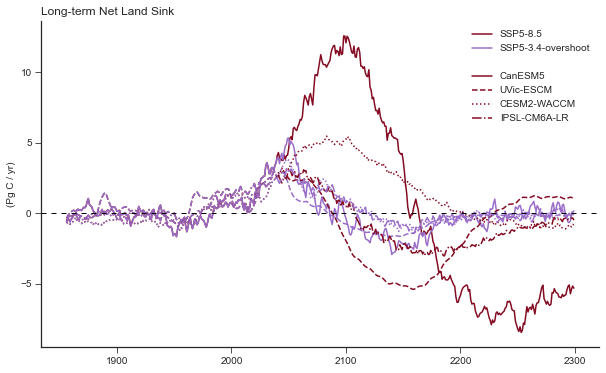

In [13]:
ax = plt.subplot(111)

linelist = []
for model_i in range(nmodels):
    linelist.append(ax.plot(years, nbp_trajectories_2exp[model_i,0,:], color=ssp585_color, linestyle=dashlist[model_i]))
    linelist.append(ax.plot(years, nbp_trajectories_2exp[model_i,1,:], color=ssp534os_color, linestyle=dashlist[model_i]))
    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Land Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)

plt.legend((linelist[0][0], linelist[1][0], emptyline, linelist[0][0], linelist[2][0], linelist[4][0], linelist[6][0],), labels_list, frameon=False)


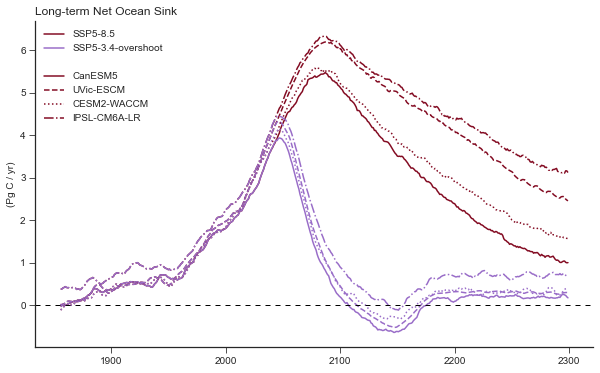

In [14]:
ax = plt.subplot(111)

linelist = []
for model_i in range(nmodels):
    linelist.append(ax.plot(years, fgco2_trajectories_2exp[model_i,0,:], color=ssp585_color, linestyle=dashlist[model_i]))
    linelist.append(ax.plot(years, fgco2_trajectories_2exp[model_i,1,:], color=ssp534os_color, linestyle=dashlist[model_i]))
    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Ocean Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)
emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)

plt.legend((linelist[0][0], linelist[1][0], emptyline, linelist[0][0], linelist[2][0], linelist[4][0], linelist[6][0],), labels_list, frameon=False)

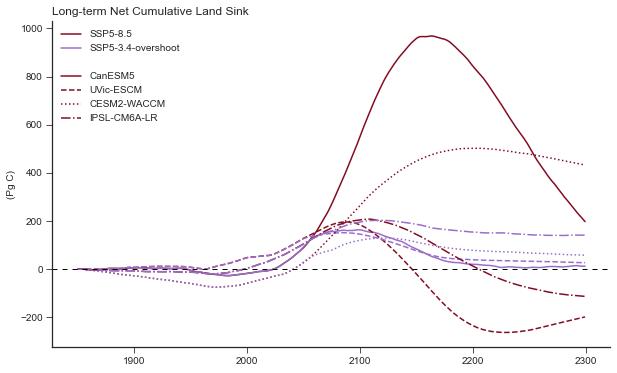

In [15]:
ax = plt.subplot(111)

linelist = []
for model_i in range(nmodels):
    linelist.append(ax.plot(years, nbp_trajectories_2exp[model_i,0,:].cumsum(), color=ssp585_color, linestyle=dashlist[model_i]))
    linelist.append(ax.plot(years, nbp_trajectories_2exp[model_i,1,:].cumsum(), color=ssp534os_color, linestyle=dashlist[model_i]))
    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C)')
plt.title('Long-term Net Cumulative Land Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)
emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)

plt.legend((linelist[0][0], linelist[1][0], emptyline, linelist[0][0], linelist[2][0], linelist[4][0], linelist[6][0],), labels_list, frameon=False)

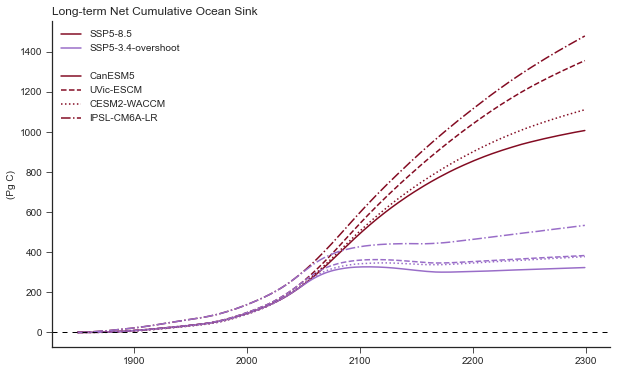

In [16]:
ax = plt.subplot(111)

linelist = []
for model_i in range(nmodels):
    linelist.append(ax.plot(years, fgco2_trajectories_2exp[model_i,0,:].cumsum(), color=ssp585_color, linestyle=dashlist[model_i]))
    linelist.append(ax.plot(years, fgco2_trajectories_2exp[model_i,1,:].cumsum(), color=ssp534os_color, linestyle=dashlist[model_i]))
    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C)')
plt.title('Long-term Net Cumulative Ocean Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)
emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)

plt.legend((linelist[0][0], linelist[1][0], emptyline, linelist[0][0], linelist[2][0], linelist[4][0], linelist[6][0],), labels_list, frameon=False)

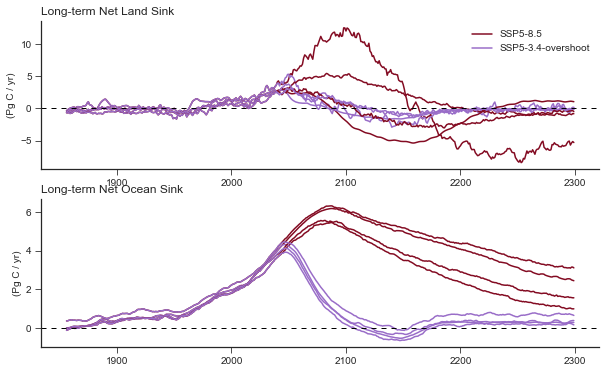

In [17]:
ax = plt.subplot(211)

for model_i in range(nmodels):
    ax.plot(years, nbp_trajectories_2exp[model_i,0,:], color=ssp585_color)
    ax.plot(years, nbp_trajectories_2exp[model_i,1,:], color=ssp534os_color)
    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Land Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)

ax = plt.subplot(212)

for model_i in range(nmodels):
    ax.plot(years, fgco2_trajectories_2exp[model_i,0,:], color=ssp585_color)
    ax.plot(years, fgco2_trajectories_2exp[model_i,1,:], color=ssp534os_color)
    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Ocean Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)

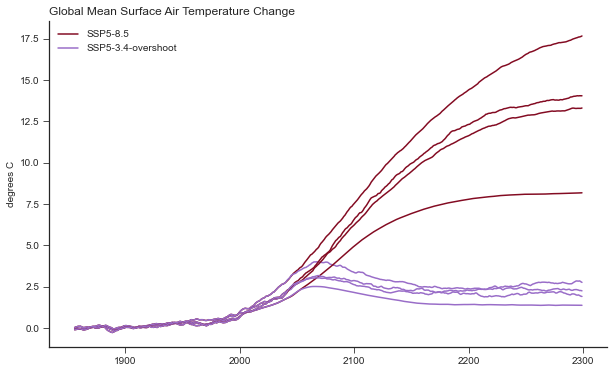

In [18]:
ax = plt.subplot(111)

for model_i in range(nmodels):
    ax.plot(years, tas_trajectories_2exp[model_i,0,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp585_color)
    ax.plot(years, tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color)
    
#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('degrees C')
plt.title('Global Mean Surface Air Temperature Change',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)

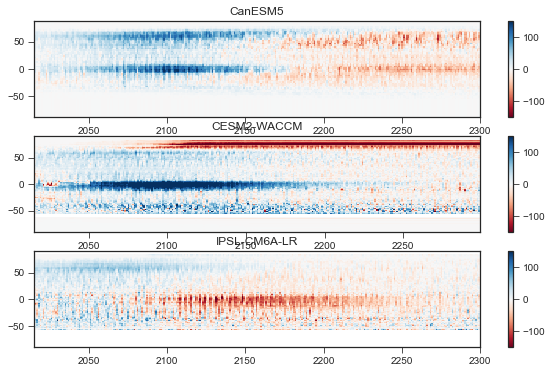

In [19]:
### plot zonal-mean fields of NBP over time
max_val = 150 #saturating color in g C / m2 / yr
n_gridded = 0
for model_i in range(nmodels):
    if globally_gridded[model_i]:
        n_gridded = n_gridded+1
fig, axs = plt.subplots(n_gridded)
idx = -1
for model_i in range(nmodels):
    if globally_gridded[model_i]:
        idx = idx+1
        c = axs[idx].pcolormesh(np.arange(len(zonal_mean_anual_nbp_list[model_i][1].time))+2015, zonal_mean_anual_nbp_list[model_i][1].lat, zonal_mean_anual_nbp_list[model_i][1].transpose()*86400.*365.*1e3, rasterized=True, vmin=-max_val, vmax=max_val, cmap='RdBu')
        fig.colorbar(c, ax=axs[idx])
        axs[idx].set_title(models_list[model_i])

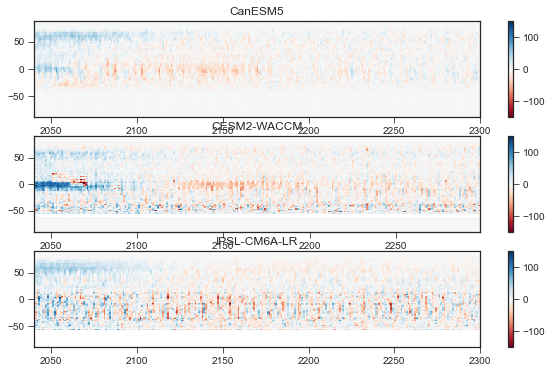

In [20]:
fig, axs = plt.subplots(n_gridded)
idx = -1
for model_i in range(nmodels):
    if globally_gridded[model_i]:
        idx = idx+1
        c = axs[idx].pcolormesh(np.arange(len(zonal_mean_anual_nbp_list[model_i][2].time))+2040, zonal_mean_anual_nbp_list[model_i][2].lat, zonal_mean_anual_nbp_list[model_i][2].transpose()*86400.*365.*1e3, rasterized=True, vmin=-max_val, vmax=max_val, cmap='RdBu')
        fig.colorbar(c, ax=axs[idx])
        axs[idx].set_title(models_list[model_i])

In [21]:
## now load the atmospheric mole fraction of co2 to calculate the cumulative emissions
filename_atmco2_hist = 'mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_CMIP_UoM-CMIP-1-2-0_gr1-GMNHSH_0000-2014.nc'
filename_atmco2_ssp585 = 'mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-REMIND-MAGPIE-ssp585-1-2-1_gr1-GMNHSH_2015-2500.nc'
filename_atmco2_ssp534os = 'mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-REMIND-MAGPIE-ssp534-over-1-2-1_gr1-GMNHSH_2015-2500.nc'

tmin_co2mf_hist = 0
tmin_co2mf_ssps = 2015


#startyear_exps = [1850, 2015, 2040]
#endyear_exps = [2014, 2299, 2299]

co2_mf_ts = xr.DataArray(np.ma.masked_all((2,nyears_total)), dims=['scenarios','time'])

co2_molefrac_hist = xr.open_dataset(filename_atmco2_hist, decode_times=False)
hist_co2_ts = co2_molefrac_hist['mole_fraction_of_carbon_dioxide_in_air'].isel(sector=1, time=slice(startyear_exps[0]-tmin_co2mf_hist,endyear_exps[0]-tmin_co2mf_hist+1))
co2_mf_ts[:,0:endyear_exps[0]-startyear_exps[0]+1] = hist_co2_ts

co2_molefrac_ssp585 = xr.open_dataset(filename_atmco2_ssp585, decode_times=False)
ssp585_co2_ts = co2_molefrac_ssp585['mole_fraction_of_carbon_dioxide_in_air'].isel(sector=1, time=slice(startyear_exps[1]-tmin_co2mf_ssps,endyear_exps[1]-tmin_co2mf_ssps+1))
co2_mf_ts[0,startyear_exps[1]-startyear_exps[0]:endyear_exps[1]-startyear_exps[0]+1] = ssp585_co2_ts

co2_molefrac_ssp534os = xr.open_dataset(filename_atmco2_ssp534os, decode_times=False)
ssp534os_co2_ts = co2_molefrac_ssp534os['mole_fraction_of_carbon_dioxide_in_air'].isel(sector=1, time=slice(startyear_exps[1]-tmin_co2mf_ssps,endyear_exps[1]-tmin_co2mf_ssps+1))
co2_mf_ts[1,startyear_exps[1]-startyear_exps[0]:endyear_exps[1]-startyear_exps[0]+1] = ssp534os_co2_ts

#co2_mf_ts.plot()


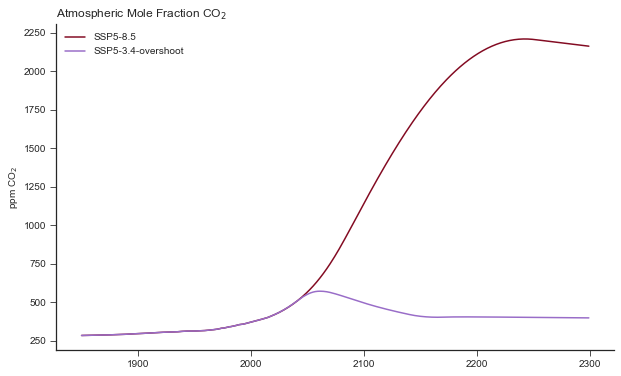

In [22]:
ax = plt.subplot(111)

ax.plot(years, co2_mf_ts[0,:], color=ssp585_color)
ax.plot(years, co2_mf_ts[1,:], color=ssp534os_color)
    
#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('ppm CO$_2$')
plt.title('Atmospheric Mole Fraction CO$_2$',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)

In [23]:
### now calculate cumulative emissions
ppm_to_pgc = 2.124  # from le quere 2018, which gets it from ballantyne et al 2012

atm_co2_pgc = (co2_mf_ts - co2_mf_ts.isel(time=0)) * ppm_to_pgc
cum_land_carbon_pgc = nbp_trajectories_2exp.cumsum(dim='time')
cum_ocn_carbon_pgc = fgco2_trajectories_2exp.cumsum(dim='time')

cum_emissions_pgc = atm_co2_pgc + cum_land_carbon_pgc + cum_ocn_carbon_pgc

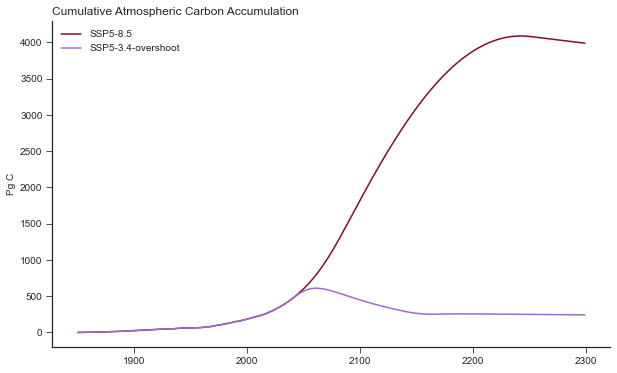

In [24]:
ax = plt.subplot(111)

ax.plot(years, atm_co2_pgc[0,:], color=ssp585_color)
ax.plot(years, atm_co2_pgc[1,:], color=ssp534os_color)
    
#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('Pg C')
plt.title('Cumulative Atmospheric Carbon Accumulation',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)

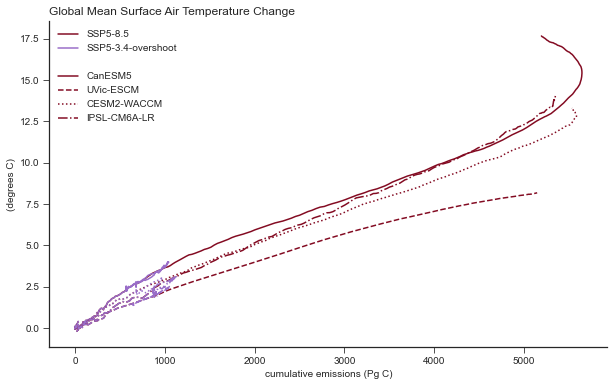

In [25]:
ax = plt.subplot(111)


linelist = []
for model_i in range(nmodels):
    linelist.append(ax.plot(cum_emissions_pgc[0,:, model_i], tas_trajectories_2exp[model_i,0,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp585_color, linestyle=dashlist[model_i]))
    linelist.append(ax.plot(cum_emissions_pgc[1,:, model_i], tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color, linestyle=dashlist[model_i]))

emptyline, = ax.plot([0.,0.], [0., 0.], linewidth=0.)

#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(degrees C)')
plt.xlabel('cumulative emissions (Pg C)')
plt.title('Global Mean Surface Air Temperature Change',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend((linelist[0][0], linelist[1][0], emptyline, linelist[0][0], linelist[2][0], linelist[4][0], linelist[6][0],), labels_list, frameon=False)

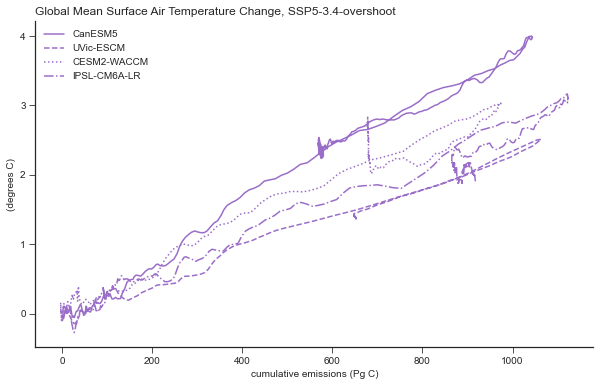

In [26]:
### just show the SSP5-3.4os
ax = plt.subplot(111)


linelist = []
for model_i in range(nmodels):
    linelist.append(ax.plot(cum_emissions_pgc[1,:, model_i], tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color, linestyle=dashlist[model_i]))

emptyline, = ax.plot([0.,0.], [0., 0.], linewidth=0.)

#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(degrees C)')
plt.xlabel('cumulative emissions (Pg C)')
plt.title('Global Mean Surface Air Temperature Change, SSP5-3.4-overshoot',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend((linelist[0][0], linelist[1][0], linelist[2][0], linelist[3][0],), models_list, frameon=False)

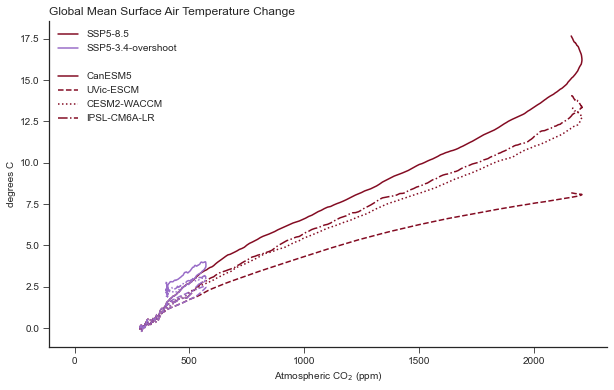

In [27]:
ax = plt.subplot(111)

dashlist = ['solid','dashed','dotted','dashdot']

model_i = 0
l1, = ax.plot(co2_mf_ts[0,:], tas_trajectories_2exp[model_i,0,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp585_color, linestyle=dashlist[model_i])
l2, = ax.plot(co2_mf_ts[1,:], tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color, linestyle=dashlist[model_i])

model_i = 1
l3, = ax.plot(co2_mf_ts[0,:], tas_trajectories_2exp[model_i,0,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp585_color, linestyle=dashlist[model_i])
l4, = ax.plot(co2_mf_ts[1,:], tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color, linestyle=dashlist[model_i])

model_i = 2
l5, = ax.plot(co2_mf_ts[0,:], tas_trajectories_2exp[model_i,0,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp585_color, linestyle=dashlist[model_i])
l6, = ax.plot(co2_mf_ts[1,:], tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color, linestyle=dashlist[model_i])

model_i = 3
l7, = ax.plot(co2_mf_ts[0,:], tas_trajectories_2exp[model_i,0,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp585_color, linestyle=dashlist[model_i])
l8, = ax.plot(co2_mf_ts[1,:], tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color, linestyle=dashlist[model_i])

l9, = ax.plot([0.,0.], [0., 0.], linewidth=0.)

#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('degrees C')
plt.xlabel('Atmospheric CO$_2$ (ppm)')
plt.title('Global Mean Surface Air Temperature Change',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

labels_list = ('SSP5-8.5', 'SSP5-3.4-overshoot', '', models_list[0], models_list[1], models_list[2], models_list[3])
#plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)
plt.legend((l1, l2, l9, l1, l3, l5, l7,), labels_list, frameon=False)

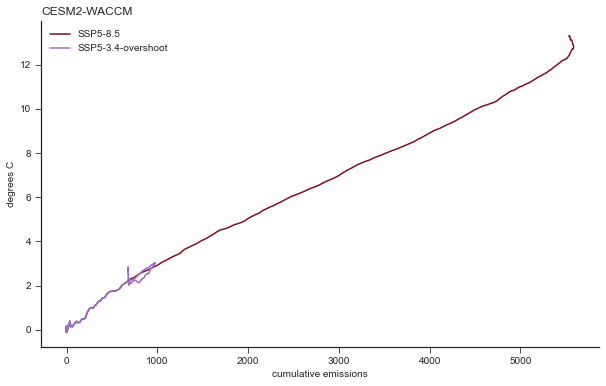

In [28]:
### look at any one model on its own...
model_i = 2

ax = plt.subplot(111)
ax.plot(cum_emissions_pgc[0,:, model_i], tas_trajectories_2exp[model_i,0,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp585_color)
ax.plot(cum_emissions_pgc[1,:, model_i], tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color)
#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('degrees C')
plt.xlabel('cumulative emissions')
plt.title(models_list[model_i],loc='left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)

In [44]:
### i want to be able to calculate the co2-attributable warming, which equals warming * RF_CO2 / RF_total
ghg_list_long = ['c-c4f8','c2f6','c3f8','c4f10','c5f12','c6f14','c7f16','c8f18','carbon-dioxide','carbon-tetrachloride','cf4','cfc11','cfc113','cfc114','cfc115','cfc11eq','cfc12','cfc12eq','ch2cl2','ch3ccl3','chcl3','halon1211','halon1301','halon2402','hcfc141b','hcfc142b','hcfc22','hfc125','hfc134a','hfc134aeq','hfc143a','hfc152a','hfc227ea','hfc23','hfc236fa','hfc245fa','hfc32','hfc365mfc','hfc4310mee','methane','methyl-bromide','methyl-chloride','nf3','nitrous-oxide','sf6','so2f2']
ghg_list_short = ['carbon-dioxide','methane','nitrous-oxide','cfc12eq','hfc134aeq']

scenario_filename_suffixes = ['-in-air_input4MIPs_GHGConcentrations_CMIP_UoM-CMIP-1-2-0_gr1-GMNHSH_0000-2014.nc',
                              '-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-REMIND-MAGPIE-ssp585-1-2-1_gr1-GMNHSH_2015-2500.nc',
                              '-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-REMIND-MAGPIE-ssp534-over-1-2-1_gr1-GMNHSH_2015-2500.nc']
filename_prefix = 'mole-fraction-of-'

### define some functino s to calculate radiative forcing.  use table 3 of meinshausen et al 2019
def rf_co2(co2, n20):
    camax = 1808.
    c0 = 277.15
    a1 = -2.4785e-7 # W m-2 ppm-2
    b1 = 0.00075906 # W m-2 ppm-1
    c1 = -0.0021492 # W m-2 ppb -0.5
    d1 = 5.2488     # W m-2
    if co2 <= camax:
        aprime = d1 - b1**2/(2*a1)
    elif co2 < c0:
        aprime = d1
    else:
        aprime = d1 + a1 * (co2 - c0)**2 + b1*(co2 - c0)
    alpha_n20 = c1 * sqrt(n2o)
    return((aprime + alpha_n2o) * ln(co2/c0))
    
def rf_n2o(co2, n2o, methane):
    a2 = -0.00034197  # W m-2 ppm-1
    b2 = 0.00025455   # W m-2 ppb-1
    c2 = -0.00024357  # W m-2 ppb-1
    d2 = 0.12173      # W m-2 ppb-0.5
    N0 = 273.87       # ppb
    return((a2*sqrt(co2)+b2*sqrt(n2o)+c2*sqrt(methane)+d2)*(sqrt(n2o)-sqrt(N0)))

def rf_methane(methane, n2o):
    a3 = -8.9603e-05 #W m-2 ppb-1 
    b3 = -0.00012462 #W m-2 ppb-1 
    d3 = 0.045194    #W m-2 ppb-0.5 
    M0 = 731.41      #ppb
    return((a3*sqrt(methane)+b3*sqrt(n2o)+d3)*(sqrt(methane)-sqrt(M0)))

for scen in scenario_filename_suffixes:
    files_list = []
    for ghg in ghg_list_short:
        files_list.append(xr.open_dataset(filename_prefix+ghg+scen, decode_times=False))


### below is code to search the ESG and see what variables exist for the 21st and 22nd centuries

In [29]:
#!/usr/bin/env python
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        ##cdk print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

In [30]:
century_strings = ['-22', '-23']

In [31]:
ssp585_nbp_files = esgf_search(variable_id='nbp', experiment_id='ssp585')
for url in ssp585_nbp_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p1f1/Lmon/nbp/gn/v20190429/nbp_Lmon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p1f1/Lmon/nbp/gn/v20190429/nbp_Lmon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Lmon/nbp/gn/v20200702/nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Lmon/nbp/gn/v20200702/nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Lmon/nbp/gn/v20200702/nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_225101-229912.nc
http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp585/r1

In [32]:
ssp534os_nbp_files = esgf_search(variable_id='nbp', experiment_id='ssp534-over')
for url in ssp534os_nbp_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Lmon/nbp/gn/v20190306/nbp_Lmon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Lmon/nbp/gn/v20190429/nbp_Lmon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp534-over/r1i1p1f1/Lmon/nbp/gn/v20200701/nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp534-over/r1i1p1f1/Lmon/nbp/gn/v20200701/nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_220101-225012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp534-over/r1i1p1f1/Lmon/nbp/gn/v20200701/nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_225101-229912.nc
http://esgf-data1.llnl.gov/thredds/dodsC/css03_

In [33]:
ssp534os_fgco2_files = esgf_search(variable_id='fgco2', experiment_id='ssp534-over')
for url in ssp534os_fgco2_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Omon/fgco2/gn/v20190306/fgco2_Omon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc
http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Oyr/fgco2/gn/v20190429/fgco2_Oyr_CanESM5_ssp534-over_r1i1p1f1_gn_2101-2300.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Omon/fgco2/gn/v20190429/fgco2_Omon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Oyr/fgco2/gn/v20190429/fgco2_Oyr_CanESM5_ssp534-over_r1i1p1f1_gn_2101-2300.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp534-over/r1i1p1f1/Omon/fgco2/gn/v20200701/fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroo

In [34]:
ssp585_fgco2_files = esgf_search(variable_id='fgco2', experiment_id='ssp585')
for url in ssp585_fgco2_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p1f1/Oyr/fgco2/gn/v20190429/fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2181-2300.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p1f1/Omon/fgco2/gn/v20190429/fgco2_Omon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p1f1/Oyr/fgco2/gn/v20190429/fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2181-2300.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Omon/fgco2/gn/v20200702/fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Omon/fgco2/gn/v20200702/fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/

In [ ]:
ssp585_fgco2_files = esgf_search(variable_id='fgco2', experiment_id='ssp585')
for url in ssp585_fgco2_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)